In [44]:
import pandas
from matplotlib import pyplot as plt
import numpy as np
from rich import print as rprint

In [54]:
trace_file = "../traces/philly.csv"
trace = pandas.read_csv(trace_file)
rprint(f"Read {len(trace)} rows from {trace_file}")
# convert time to seconds
trace['time'] = pandas.to_datetime(trace['timestamp']).astype(np.int64) / 1e9
trace['time'] = trace['time'] - trace['time'].min()
# sort by timestamp
trace = trace.sort_values(by=['time'], ascending=True)
trace.drop(columns=['timestamp'], inplace=True)
# trace.to_csv("../traces/helios_saturn_normalized.csv", index=False)
rprint(f"Headers: {trace.columns}")
# bucket by 1-hour
trace['hour'] = trace['time'] // 3600

Read 82247 rows from ../traces/philly.csv

Headers: Index(['duration', 'num_gpus', 'gpu_time', 'cluster', 'time'], dtype='object')

In [55]:
# standardize plot
def standardize(size=(10, 5)):
  plt.gcf().set_size_inches(*size)
  plt.grid(True)
  # set dpi
  plt.gcf().set_dpi(100)
  # set font
  plt.rcParams.update({'font.size': 12})

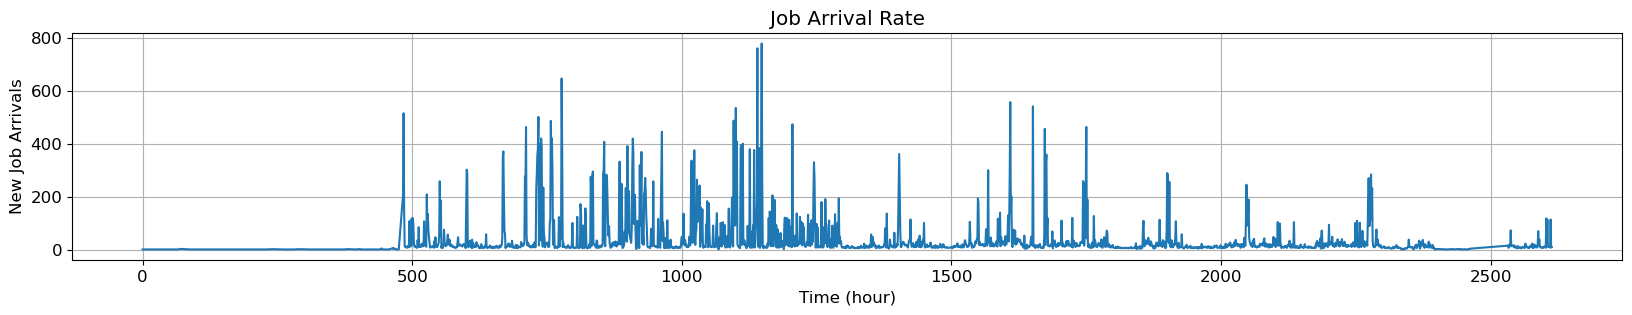

In [56]:
# plot job arrival rates
counts = trace['hour'].value_counts().sort_index()
plt.plot(counts.index, counts.values)
standardize(size=(20, 3))
plt.xlabel("Time (hour)")
plt.ylabel("New Job Arrivals")
plt.title("Job Arrival Rate")
plt.savefig("../traces/philly_arrival_rates.png", bbox_inches='tight', dpi=300)

### Process Alibaba Cluster Trace v2020


In [192]:
# read the raw data
csv_file = "../traces/pai_task_table.csv"
raw_data = pandas.read_csv(csv_file, names=["job_name", "task_name", "inst_num", "status", "start_time", "end_time", "plan_cpu", "plan_mem", "plan_gpu", "gpu_type"], header=None)
# drop job_name, task_name, inst_num, plan_cpu, gpu_type, plan_mem columns
raw_data.drop(columns=["job_name", "task_name", "inst_num", "plan_cpu", "gpu_type", "plan_mem"], inplace=True)
rprint(f"Columns: {raw_data.columns}")
rprint(f"Number of rows: {len(raw_data)}")
rprint(f"Unique status values: {raw_data['status'].unique()}")

Columns: Index(['status', 'start_time', 'end_time', 'plan_gpu'], dtype='object')

Number of rows: 1261050

Unique status values: ['Terminated' 'Failed' 'Running' 'Waiting']

In [193]:
# normalize time to min 0
min_time = min(raw_data['start_time'].min(), raw_data['end_time'].min())
raw_data['start_time'] = (raw_data['start_time'] - min_time)
raw_data['end_time'] = (raw_data['end_time'] - min_time)
# compute run time
raw_data['duration'] = raw_data['end_time'] - raw_data['start_time']
# compute GPU time
raw_data['gpu_time'] = raw_data['duration'] * (raw_data['plan_gpu'] / 100)
raw_data['gpu_time'] = raw_data['gpu_time'].round(0)
# set start_time as submission_time
raw_data['time'] = raw_data['start_time'].round(0)
raw_data.sort_values(by=['time'], ascending=True, inplace=True)
raw_data['hour'] = raw_data['time'] // 3600
# drop start_time and end_time
raw_data.drop(columns=['start_time', 'end_time'], inplace=True)
# set num_gpus as (plan_gpu/100) [plan_gpu is in percentage]
raw_data['num_gpus'] = raw_data['plan_gpu'] / 100
# drop plan_gpu, status
raw_data.drop(columns=['plan_gpu', 'status'], inplace=True)
rprint(f"Columns: {raw_data.columns}")

Columns: Index(['duration', 'gpu_time', 'time', 'hour', 'num_gpus'], dtype='object')

Text(0.5, 1.0, 'CDF of Task GPU Time (s) [RAW]')

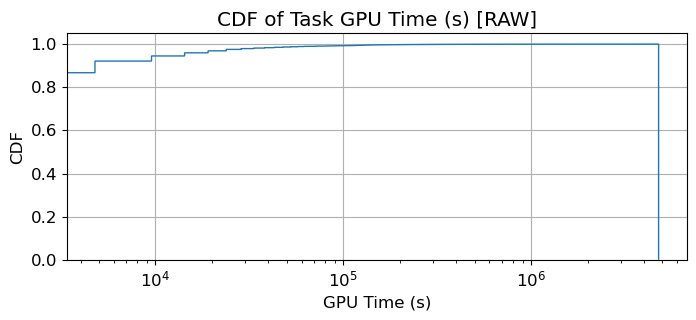

In [194]:
# plot cdf of run time
run_time = raw_data['gpu_time']
run_time.hist(cumulative=True, density=1, histtype='step', bins=1000)
standardize(size=(8, 3))
plt.xlabel("GPU Time (s)")
plt.ylabel("CDF")
plt.xscale('log')
plt.title("CDF of Task GPU Time (s) [RAW]")

In [195]:
# filter out rows with gpu_time < 10 seconds
selector = raw_data['gpu_time'] >= 60
filtered_data = raw_data[selector]
rprint(f"Filtered number of rows: {len(filtered_data)}")

Filtered number of rows: 576809

In [196]:
# save filtered data
filtered_data.to_csv("../traces/alibaba_pai_normalized.csv", index=False)

Text(0.5, 1.0, 'CDF of Task Run Time (s)')

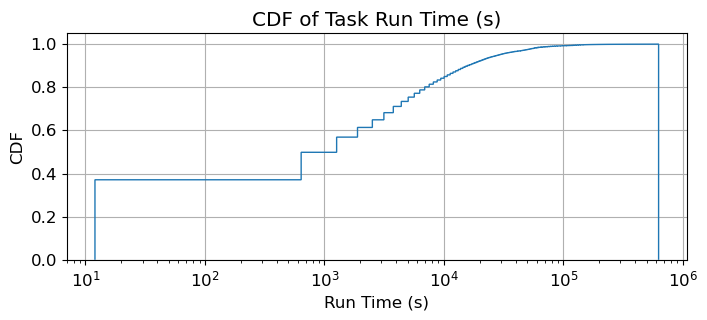

In [197]:

# plot cdf of run time
run_time = filtered_data['duration']
run_time.hist(cumulative=True, density=1, histtype='step', bins=1000)
standardize(size=(8, 3))
plt.xlabel("Run Time (s)")
plt.ylabel("CDF")
plt.xscale('log')
plt.title("CDF of Task Run Time (s)")

Text(0.5, 1.0, 'CDF of Task GPU Time (s)')

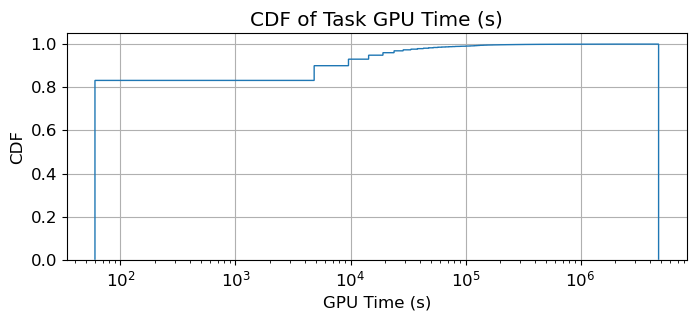

In [198]:

# plot cdf of GPU time
gpu_time = filtered_data['gpu_time']
gpu_time.hist(cumulative=True, density=1, histtype='step', bins=1000)
standardize(size=(8, 3))
plt.xlabel("GPU Time (s)")
plt.ylabel("CDF")
plt.xscale('log')
plt.title("CDF of Task GPU Time (s)")

Text(0.5, 1.0, 'CDF of Task #GPUs')

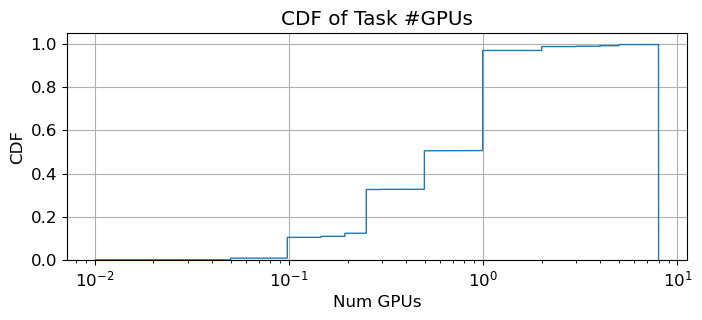

In [199]:
# plot cdf of num GPUs
ngpus = filtered_data['num_gpus']
ngpus.hist(cumulative=True, density=1, histtype='step', bins=1000)
standardize(size=(8, 3))
plt.xlabel("Num GPUs")
plt.ylabel("CDF")
plt.xscale('log')
plt.title("CDF of Task #GPUs")

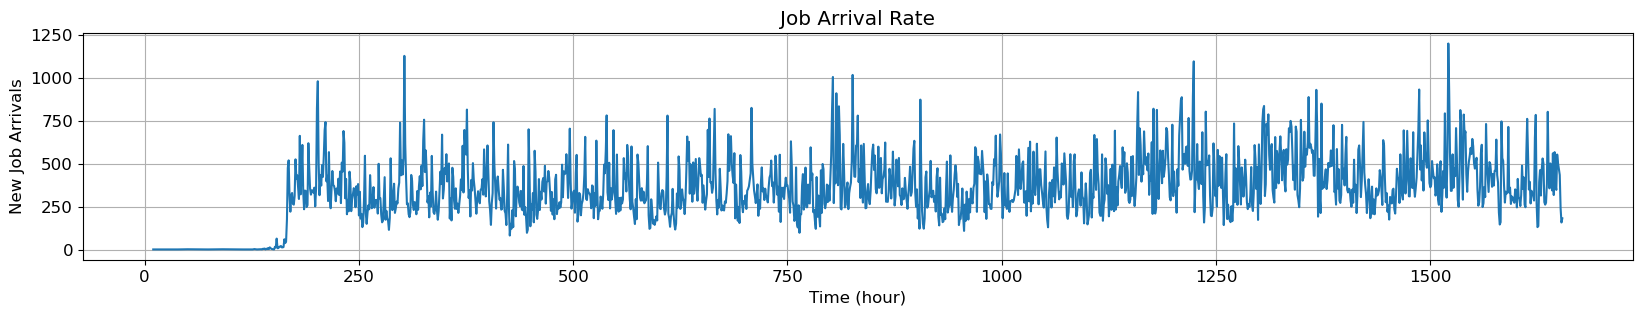

In [201]:
# plot job arrival rates
counts = filtered_data['hour'].value_counts().sort_index()
plt.plot(counts.index, counts.values)
standardize(size=(20, 3))
plt.xlabel("Time (hour)")
plt.ylabel("New Job Arrivals")
plt.title("Job Arrival Rate")
plt.savefig("../traces/alibaba_pai_arrival_rates.png", bbox_inches='tight', dpi=300)